In [1]:
import sys
import platform
from os.path import join, exists, abspath, dirname
from os import getcwd, makedirs
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm, colors
import scipy
from scipy.stats import ttest_1samp, pearsonr
from scipy.io import loadmat
from sklearn.metrics import r2_score
import seaborn as sns
import h5py

from tqdm import tqdm

In [2]:
import nibabel as nb
from nilearn import plotting, image
from nipype.interfaces import fsl

In [3]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/home/sungbeenpark/github'

In [4]:
dname = join(dir_git,'nitools')
sys.path.append(dname)
import nitools as nt

In [5]:
dname = join(dir_git,'SUITPy')
sys.path.append(dname)
import SUITPy as suit

In [6]:
dname = join(dir_git)
sys.path.append(dname)
import surfAnalysisPy as surf

In [7]:
dname = join(dir_git,'Functional_Fusion')
sys.path.append(dname)
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

In [8]:
dname = join(dir_git,'fracridge')
sys.path.append(dname)
from fracridge import fracridge

In [9]:
dname = join(dir_git,'GLMsingle')
sys.path.append(dname)
import glmsingle
from glmsingle.glmsingle import getcanonicalhrflibrary
from glmsingle.utils.squish import squish

In [10]:
dname = join(dir_git,'AnatSearchlight')
sys.path.append(dname)
import AnatSearchlight.searchlight as sl

In [11]:
dname = join(dir_git,'SeqSpatialSupp_fMRI')
sys.path.append(dname)
from SSS import deal_spm
from SSS import util as su
from SSS import plot as splt
from SSS import image as simage
from SSS import glmsingle as ssingle

---

In [12]:
border = simage.get_border(join(dir_git,'surfAnalysisPy'))

---

In [13]:
glm = 1
dir_glm = ssingle.get_dir_glmsingle(glm)
dir_glm

'/mnt/f/SeqSpatialSupp_fMRI/GLMsingle/glm_1'

In [14]:
dir_work = join(su.get_dir_SSS(),'scripts/mysearchlight')
exists(dir_work)

True

---

To define a searchlight we need a:

- Pial Surface (individual)
- Gray Matter Mask (individual)
- Functional mask image (mask.nii from GLM) telling us which voxels are availabe for searchlight analysis

If we want to calculate the searchlight only for a part of a the surface, we can use a roi_specification (i.e. excluding the medial wall).

The searchlight can be specified to have a specific radius in mm (on the surface) or a specific number of voxels.

In [15]:
# Give it an appropriate structure name: Used for generating cifti-files for output
mysearchlight = sl.SearchlightSurface('left_cortex')

In [16]:
# These are the inndividual surfaces and the mask
subj = 'S01'
white, pial, mask = simage.get_WPM(subj=subj, glm=glm)

In [17]:
# Optionally, you can define a roi-mask for the searchlight region on the surface. Centers outside of the mask will be ignored.
# Instead of a gifti-image you can also use a numpy array with the indices of the vertices that should be included in the searchlight.
roi_mask = join(dir_git,'AnatSearchlight/examples/tpl-fs32k_hemi-L_mask.label.gii')

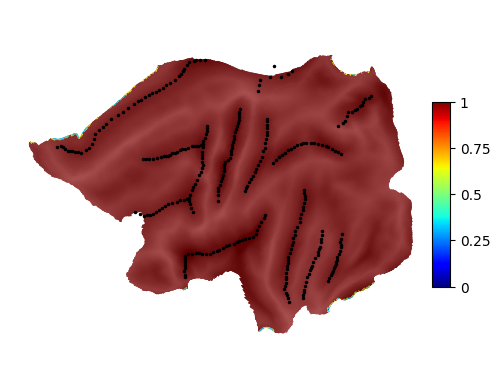

In [18]:
g = surf.plot.plotmap(
    data=roi_mask,
    surf='fs32k_L',
    alpha=0.7,
    cmap=cm.jet, colorbar=True,
    borders=border, bordercolor='black', bordersize=3,
    overlay_type='func', render='matplotlib'
)

In [31]:
# Here we defining
mysearchlight.define(surfs=[pial,white], mask_img=mask, roi=roi_mask, maxradius=30)
mysearchlight.save(join(dir_work,'%s.h5'%subj))

Processing center 0 of 29759
Processing center 1000 of 29759
Processing center 2000 of 29759
Processing center 3000 of 29759
Processing center 4000 of 29759
Processing center 5000 of 29759
Processing center 6000 of 29759
Processing center 7000 of 29759
Processing center 8000 of 29759
Processing center 9000 of 29759
Processing center 10000 of 29759
Processing center 11000 of 29759
Processing center 12000 of 29759
Processing center 13000 of 29759
Processing center 14000 of 29759
Processing center 15000 of 29759
Processing center 16000 of 29759
Processing center 17000 of 29759
Processing center 18000 of 29759


IndexError: index -1 is out of bounds for axis 0 with size 0

In [ ]:
# You can now use the pre-computed searchlight.

mySearchlight = sl.load('searchlight_surf.h5')
print(f'Average size of the searchlight: {mySearchlight.radius.mean():.1f} mm')
print(f'Average number of voxels: {mySearchlight.nvoxels.mean():.1f}')

---

## Run mean beta searchlight

In [ ]:
sn_list = [101, 102, 103, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115]
glm = 1
hem = ['L', 'R']
sl_name = ['left_cortex', 'right_cortex']
conds = ['lhand', 'rhand', 'bi']

def mean_function(data):
    # mean_voxels = np.mean(data, axis=1)
    # mean_beta = np.mean(mean_voxels, axis=0)
    # std_beta = np.std(mean_voxels, axis=0, ddof=1)
    # # t statistics:
    # t_stats = (mean_beta) / (std_beta / np.sqrt(len(mean_voxels)))

    mean_beta = np.nanmean(data[:-1, :])

    return mean_beta

for sn in sn_list:
    try:
        # run mean:
        for cond in conds:
                # regressor info:
                reginfo = pd.read_table(os.path.join(baseDir, f'glm{glm}', f's{sn}', 'reginfo.tsv'))
                # get indices of the regressors of interest:
                regressors_of_interest = reginfo[reginfo.name.str.contains(cond)].index.tolist()

                datafiles = [os.path.join(baseDir, f'glm{glm}', f's{sn}', f'beta_{i+1:04d}.nii') for i in regressors_of_interest]
                datafiles.append(os.path.join(baseDir, f'glm{glm}', f's{sn}', 'ResMS.nii'))
                
                for i, h in enumerate(hem):
                        S = sl.load(os.path.join(analysisDir,'searchlight',f'sl_{h}_s{sn}.h5'))
                        results = S.run(datafiles, mean_function, verbose=False)
                        S.data_to_cifti(results, outfilename=os.path.join(baseDir, 'searchlight', f'glm{glm}_{cond}_s{sn}_{h}_cortex.dscalar.nii'))

    except Exception as e:
        print(f"Error processing subject {sn}, {e}")
        continue




## Run MVPA searchlight

In [ ]:
path = '/Users/aghavamp/Desktop/Projects/bimanual_wrist/data/fMRI/glmsingle/s101'

# find all nifti files in the directory
nifti_files = glob.glob(os.path.join(path, 'beta_*.nii'))

# load the nifti files
nifti_data = [nb.load(nifti_file) for nifti_file in nifti_files]

# extract the data from the nifti files and make a (x,y,z,t) array
data_arrays = [nifti.get_fdata() for nifti in nifti_data]
# stack the data arrays along a new dimension
data = np.stack(data_arrays, axis=-1)

data.shape



In [ ]:
# flatten the data to (x*y*z, t) shape
data_flat = data.reshape(-1, data.shape[-1])
data_flat.shape

# how many rows do we have with full non nan values?
non_nan_rows = ~np.isnan(data_flat).any(axis=1)
num_non_nan_rows = np.sum(non_nan_rows)
print(f"Number of rows with all non NaN values: {num_non_nan_rows}")




In [ ]:
sn_list = [101, 102, 103, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115]
glm = 'single'
hem = ['L', 'R']
sl_name = ['left_cortex', 'right_cortex']
conds = ['lhand', 'rhand', 'bi']
sn_list = [101]
def mvpa_function(data, **kwargs):
    Y = data
    partition_vec = kwargs['partition_vec']
    condition_vec = kwargs['condition_vec']

    # within partition, average the data for same conditions:
    unique_partitions = np.unique(partition_vec)
    averaged_data = []
    averaged_conditions = []
    new_partition_vec = []
    for part in unique_partitions:
        part_indices = np.where(partition_vec == part)[0]
        unique_conditions = np.unique(condition_vec[part_indices])
        for cond in unique_conditions:
            cond_indices = part_indices[condition_vec[part_indices] == cond]
            averaged_data.append(np.mean(Y[cond_indices, :], axis=0))
            averaged_conditions.append(cond)
            new_partition_vec.append(part)
    Y = np.array(averaged_data)
    condition_vec = np.array(averaged_conditions)
    partition_vec = np.array(new_partition_vec)

    # ensure weird Y is not fed to pcm:
    # Find columns that are all NaN
    all_nan_cols = np.all(np.isnan(Y), axis=0)

    # Find columns that are all zeros
    all_zero_cols = np.all(Y == 0, axis=0)

    # Combine: columns to remove (all NaN or all zeros)
    cols_to_remove = all_nan_cols | all_zero_cols

    # if cols_to_remove was not empty:
    if np.any(cols_to_remove):
        print('=================== found one! ===================')

    Y = Y[:, ~cols_to_remove]

    # if Y is empty:
    if Y.size == 0:
        return np.nan

    
    # estimate G matrix:
    G_hat,_ = pcm.est_G_crossval(Y,
                    condition_vec,
                    partition_vec,
                    X=pcm.matrix.indicator(partition_vec))
    
    D = pcm.G_to_dist(G_hat)
    n = D.shape[0]

    # heatmap of D:
    fig,ax = plt.subplots(1,1,figsize=(3,2))
    vmax_abs = np.max(np.abs(D))
    sns.heatmap(D, ax=ax, cmap='RdBu_r', vmin=-vmax_abs, vmax=vmax_abs)
    plt.show()
    
    out = np.sum(D) / (n**2 - n)
    if np.isnan(out):
        print('=================== found one! ===================')

    # mean of distances:
    return out

for sn in sn_list:
    # run MVPA:
    for cond in conds:
        print(f'Processing subject {sn}, condition {cond}...')
        # regressor info:
        reginfo = pd.read_table(os.path.join(baseDir, f'glm{glm}', f's{sn}', 'reginfo.tsv'))
        # get indices of the regressors of interest:
        regressors_of_interest = reginfo[(reginfo.name.str.contains(cond))].index.tolist()
        
        datafiles = [os.path.join(baseDir, f'glm{glm}', f's{sn}', f'beta_{i+1:04d}.nii') for i in regressors_of_interest]
        # datafiles.append(os.path.join(baseDir, f'glm{glm}', f's{sn}', 'R2.nii'))
        partition_vec = reginfo.loc[regressors_of_interest, 'run'].values
        condition_vec = reginfo.loc[regressors_of_interest, 'name'].values

        for i, h in enumerate(hem):
            S = sl.load(os.path.join(analysisDir,'searchlight',f'sl_{h}_s{sn}.h5'))
            results = S.run(datafiles, mvpa_function, {'partition_vec': partition_vec, 'condition_vec': condition_vec}, verbose=False)
            S.data_to_cifti(results, outfilename=os.path.join(baseDir, 'searchlight', f'glm{glm}_mvpa_{cond}_s{sn}_{h}_cortex.dscalar.nii'))






## Marginal left hand bimanual searchlight

In [ ]:
sn_list = [101, 102, 103, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115]
glm = 1
hem = ['L', 'R']
sl_name = ['left_cortex', 'right_cortex']

def mvpa_marginal_lhand_function(data, **kwargs):
        Y_all = data[:-1, :] * np.sqrt(data[-1,:]/100)
        Y_all = data[:-1,:] / np.sqrt(data[-1,:])
        partitions_all = kwargs['partition_vec']
        conditions_all = kwargs['condition_vec']
        
        # define the structure of the averaged data:
        angles = [0, 60, 120, 180, 240, 300]
        partitions = np.unique(partitions_all)
        conditions = angles.copy()
        Y = np.zeros((len(partitions)*len(conditions), Y_all.shape[1]))
        partition_vec = np.repeat(partitions, len(conditions))
        condition_vec = np.tile(conditions, len(partitions))
        
        # average the activity patterns and place into Y:
        for i in range(Y.shape[0]):
            what_partition = partition_vec[i]
            what_condition = condition_vec[i]

            name = f'bi:{what_condition}'
            rows = [j for j, c in enumerate(conditions_all) if name in c and partitions_all[j] == what_partition]

            # average the activity patterns:
            Y[i, :] = np.mean(Y_all[rows, :], axis=0)
            
        # estimate the G matrix:
        G_hat,_ = pcm.est_G_crossval(Y,
                        condition_vec,
                        partition_vec,
                        X=pcm.matrix.indicator(partition_vec))
        
        D = pcm.G_to_dist(G_hat)
        n = D.shape[0]
        
        # mean of distances:
        return np.sum(D)/(n**2 - n)

for sn in sn_list:
    try:
        # run marginal MVPA:
        # regressor info:
        reginfo = pd.read_table(os.path.join(baseDir, f'glm{glm}', f's{sn}', 'reginfo.tsv'))
        # get indices of the regressors of interest:
        regressors_of_interest = reginfo[reginfo.name.str.contains('bi')].index.tolist()

        datafiles = [os.path.join(baseDir, f'glm{glm}', f's{sn}', f'beta_{i+1:04d}.nii') for i in regressors_of_interest]
        datafiles.append(os.path.join(baseDir, f'glm{glm}', f's{sn}', 'ResMS.nii'))
        partition_vec = reginfo.loc[regressors_of_interest, 'run'].values
        condition_vec = reginfo.loc[regressors_of_interest, 'name'].values

        for i, h in enumerate(hem):
            S = sl.load(os.path.join(analysisDir,'searchlight',f'sl_{h}_s{sn}.h5'))
            results = S.run(datafiles, mvpa_marginal_lhand_function, {'partition_vec': partition_vec, 'condition_vec': condition_vec})
            S.data_to_cifti(results, outfilename=os.path.join(baseDir, 'searchlight', f'glm{glm}_marginal_lhand_s{sn}_{h}_cortex.dscalar.nii'))
    
    except:
            print(f'Error processing subject {sn}. Skipping...')
            continue



## test searchlight definition

In [ ]:
h = 'L'
sn = 101

S = sl.load(os.path.join(analysisDir,'searchlight',f'sl_{h}_s{sn}.h5'))

S.center_indx
S.voxel_indx
voxlist = S.voxlist

vertices = [5758, 5961]

template_nii_path = os.path.join(baseDir, 'glmsingle', f's{sn}', 'mask.nii')
mask = nb.load(template_nii_path)
sz = mask.shape
affine = mask.affine

for vert in vertices:
    center_mask = np.zeros(sz)
    searchlight = np.transpose(S.voxel_indx[:, voxlist[vert]])
    for i, j, k in searchlight:
        center_mask[i, j, k] = 1

    center_nii = nb.Nifti1Image(center_mask, affine=affine)
    nb.save(center_nii, os.path.join(baseDir, 'searchlight', f'center_s{sn}_{h}_{vert}.nii'))

# project search light to surf:
surf_white = os.path.join(baseDir,surfacewbDir, f's{sn}', f's{sn}.{h}.white.32k.surf.gii')
surf_pial = os.path.join(baseDir,surfacewbDir, f's{sn}', f's{sn}.{h}.pial.32k.surf.gii')
surf_sulc = os.path.join(baseDir,surfacewbDir, f's{sn}', f's{sn}.{h}.sulc.32k.shape.gii')

for vert in vertices:
    # Map a Nifti to the surface of left hemisphere
    DL = surf.map.vol_to_surf([os.path.join(baseDir, 'searchlight', f'center_s{sn}_{h}_{vert}.nii')], surf_pial, surf_white, stats='mode')

    fig, axs = plt.subplots(figsize=(8, 8))
    surf.plot.plotmap(DL, f'fs32k_L',
                        underlay=None,
                        underscale=[-1.5, 1],
                        alpha=.7,
                        cmap='coolwarm',
                        overlay_type='label'
                        )
    plt.show()




---